In [1]:
import pandas as pd
pd.set_option('float_format', '{:.6f}'.format)
pd.options.mode.chained_assignment = None

from prince import MCA

import numpy as np
np.random.RandomState(seed=42)

import matplotlib.pyplot as plt

import xgboost as xgb

from os.path import isfile
import pickle
import lzma

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering

from scipy.cluster.hierarchy import dendrogram
from scipy.cluster import hierarchy


from imblearn.over_sampling import SMOTE

## **Импорт и обработка данных**

В предыдущей работе я провел некоторое конструирование признаков. Добавил информацию о NaN, импутировал данные.

Однако для кластеризации эта обработка не подходит ввиду наличия категориальных данных. 

Попробую применить <a href="https://en.wikipedia.org/wiki/Multiple_correspondence_analysis">Multiple Correspondence Analysis (MCA)</a>  для категориальных данных. Использую для этого библиотеку <a href=https://github.com/MaxHalford/prince#multiple-correspondence-analysis-mca>prince</a>.

In [2]:
src_df = pd.read_csv("./data/merged_df.csv", compression='xz')

Для начала выброшу TransactionID, isFraud как бесполезные.

In [3]:
work_df = src_df.drop(['TransactionID', 'isFraud', 'Unnamed: 0'], axis=1)

In [4]:
nan_columns = list(src_df.filter(regex='_nan'))

In [5]:
mca_df = work_df[nan_columns]

Категориальными предикторами являются также M5 и id_29. 

In [6]:
mca_df = mca_df.join(work_df[['M5', 'id_29']])

In [7]:
mca_worker = MCA(n_components=2, n_iter=10, copy=True, check_input=True, engine='auto', random_state=42)

In [8]:
mca_values = mca_worker.fit_transform(mca_df)

In [9]:
mca_values.describe().T

,count,mean,std,min,25%,50%,75%,max
0,144233.000000,-0.056736,0.679294,-1.057185,-0.662898,-0.317881,0.489415,1.485478
1,144233.000000,-0.083663,0.511396,-0.905093,-0.642106,-0.006409,0.149150,2.782979


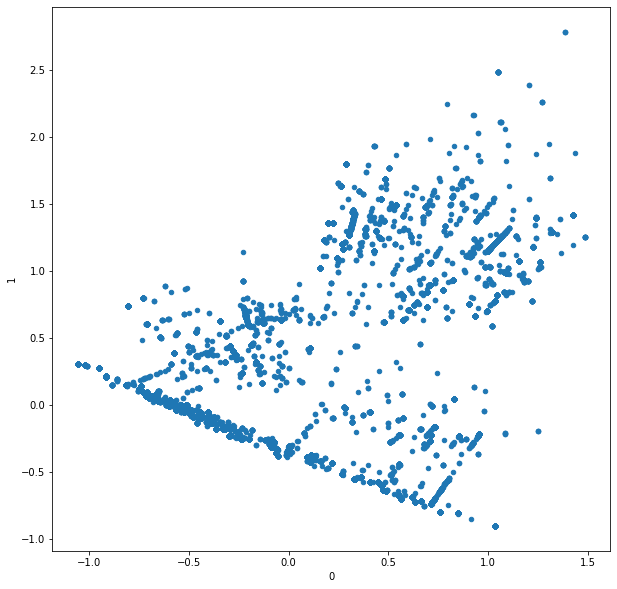

In [10]:
figure, ax = plt.subplots(figsize=(10, 10))
mca_values.plot.scatter(x=0, y=1, ax=ax)
plt.show()

Не знаю, что бы это могло значить, но выглядит вполне научно! :-)

**Эксперимент**

Интересно, а какая точность будет у классификатора на этих данных?

In [11]:
test_df = pd.DataFrame(data=mca_values.to_numpy(), columns=['MCA_1', 'MCA_2'])
test_df = test_df.join(work_df.drop(nan_columns, axis=1))
test_df = test_df.join(src_df[['isFraud']])

X = test_df.drop(['isFraud'], axis=1)
y = test_df[['isFraud']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True, random_state=42, stratify=y)

over_sampler = SMOTE(random_state=42, n_jobs=-1, sampling_strategy='minority')

X_train, y_train = over_sampler.fit_resample(X_train, y_train)

dm_train = xgb.DMatrix(X_train, y_train)
dm_test = xgb.DMatrix(X_test, y_test)

xgb_01 = xgb.XGBClassifier

if isfile("./data/models/xgb_01.xz"):
    with lzma.open("./data/models/xgb_01.xz", "rb") as m_file:
        xgb_01 = pickle.load(m_file)
else:
    xgb_01 = xgb.train(
        params={
            'objective': 'binary:logistic',
            'eval_metric': 'auc'
        },
        dtrain=dm_train,
        evals=[(dm_train, "train"), (dm_test, "validation")],
        num_boost_round=10000,
        verbose_eval=20,
        early_stopping_rounds=25
    )
    
    with lzma.open("./data/models/xgb_01.xz", "wb") as m_file:
        pickle.dump(xgb_01, m_file)
        
print("ROC-AUC: {:.6f}".format(roc_auc_score(y_test, xgb_01.predict(dm_test))))
print("Accuracy: {:.6f}".format(accuracy_score(y_test, [round(x) for x in xgb_01.predict(dm_test)])))

ROC-AUC: 0.943759
Accuracy: 0.961314


Ну, по крайней мере, радикального падения точности не произошло. 

## **Кластеризация**

**Стандартизация и сборка рабочего датасета**

In [12]:
zscored_data = StandardScaler().fit_transform(work_df.drop(nan_columns, axis=1))

clust_df = pd.DataFrame(
    data=zscored_data,
    columns=work_df.drop(nan_columns, axis=1).columns.values
)

clust_df.drop(['id_29', 'M5'], axis=1, inplace=True)
clust_df = clust_df.join(pd.DataFrame(data=mca_values.to_numpy(), columns=['MCA_1', 'MCA_2']))

clust_df.describe().T

,count,mean,std,min,25%,50%,75%,max
id_04,144233.000000,-0.000000,1.000003,-39.341701,0.083712,0.083712,0.083712,0.083712
id_20,144233.000000,-0.000000,1.000003,-2.014836,-0.911266,0.379246,0.863753,1.714698
id_24,144233.000000,0.000000,1.000003,-1.574710,-0.771115,-0.118692,0.684903,10.359866
id_33,144233.000000,-0.000000,1.000003,-1.983769,-0.914988,0.367548,0.670369,2.629800
id_22,144233.000000,0.000000,1.000003,-1.433587,-1.010588,-0.343894,1.009307,1.934556
id_02,144233.000000,-0.000000,1.000003,-1.114309,-0.678375,-0.301370,0.369431,5.176942
D4,144233.000000,0.000000,1.000003,-1.114616,-0.488223,-0.485732,-0.159479,6.070044
card1,144233.000000,0.000000,1.000003,-1.759047,-0.825341,-0.048738,1.027015,1.687325
card2,144233.000000,0.000000,1.000003,-1.816341,-0.793345,0.104896,0.959472,1.302550
card3,144233.000000,0.000000,1.000003,-3.178650,-0.601975,-0.601975,1.201697,3.572238


**Иерархическая кластеризация**

Для начала, попробую без задания количества кластеров.

Однако возникла проблема. Данный алгоритм требует много памяти и работать с датасетом целиком не получится.

Попробую поделить датасет на части и проверить при каких значениях дистанции я получу одинаковое количество кластеров для каждой из частей.

In [13]:
clusters_results = {}

idxs = clust_df.index.values

np.random.shuffle(idxs)

folds = np.array_split(ary=idxs, indices_or_sections=10)

if isfile("./data/models/clusters_results.xz"):
    with lzma.open("./data/models/clusters_results.xz", "rb") as m_file:
        clusters_results = pickle.load(m_file)
else:
    distances = [5, 20, 50, 100, 200, 400]#np.arange(120, 131, 2)

    for idx, fold in enumerate(folds):
        clusters_data = []
    
        for distance in distances:
            cluster = AgglomerativeClustering(distance_threshold=distance, n_clusters=None).fit(clust_df.iloc[fold])
            clusters_data.append((distance, cluster.n_clusters_))
    
        clusters_results[idx] = clusters_data
        print(idx)
    
    with lzma.open("./data/models/clusters_results.xz", "wb") as m_file:
        pickle.dump(clusters_results, m_file)    

In [14]:
clusters_result_df = pd.DataFrame(
    data = clusters_results
)
clusters_result_df

,0,1,2,3,4,5,6,7,8,9
0,"(5, 1763)","(5, 1786)","(5, 1774)","(5, 1793)","(5, 1797)","(5, 1755)","(5, 1770)","(5, 1772)","(5, 1794)","(5, 1787)"
1,"(20, 137)","(20, 145)","(20, 140)","(20, 144)","(20, 139)","(20, 145)","(20, 143)","(20, 137)","(20, 147)","(20, 146)"
2,"(50, 36)","(50, 34)","(50, 33)","(50, 37)","(50, 35)","(50, 34)","(50, 36)","(50, 36)","(50, 36)","(50, 35)"
3,"(100, 13)","(100, 15)","(100, 14)","(100, 13)","(100, 14)","(100, 14)","(100, 13)","(100, 14)","(100, 14)","(100, 13)"
4,"(200, 2)","(200, 3)","(200, 3)","(200, 3)","(200, 3)","(200, 2)","(200, 3)","(200, 4)","(200, 2)","(200, 3)"
5,"(400, 1)","(400, 1)","(400, 1)","(400, 1)","(400, 1)","(400, 1)","(400, 1)","(400, 1)","(400, 1)","(400, 1)"


Думаю, 100 более-менее подходит для начала. То есть, пусть будет 13-15 кластеров.

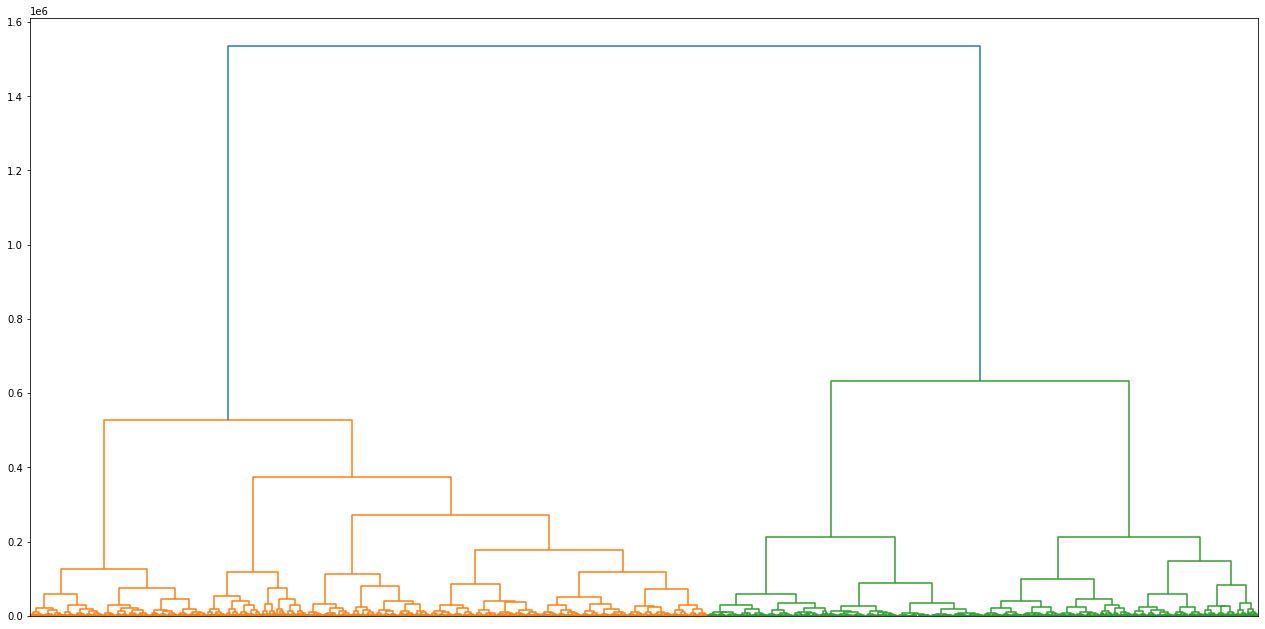

In [15]:
h_cluster = AgglomerativeClustering(distance_threshold=100, n_clusters=None).fit(clust_df.iloc[folds[4]])
z = hierarchy.linkage(h_cluster.children_, 'ward')

figure, ax = plt.subplots(1, 1, figsize=(22,11))

dn = hierarchy.dendrogram(z, ax=ax, no_labels=True)
plt.show()

In [16]:
uniques_for_0 = []
uniques_for_1 = []

for fold in folds:
    test_df = clust_df.iloc[fold]
    test_df['isFraud'] = src_df.iloc[fold]['isFraud'].values
    test_df['Cluster'] = AgglomerativeClustering(distance_threshold=100, n_clusters=None).fit_predict(clust_df.iloc[fold])
    
    uniques_for_0.append(
        np.setdiff1d(
            np.unique(test_df.loc[test_df['isFraud'] == 0]['Cluster']),
            np.unique(test_df.loc[test_df['isFraud'] == 1]['Cluster'])
        )
    )
    
    uniques_for_1.append(
        np.setdiff1d(
            np.unique(test_df.loc[test_df['isFraud'] == 1]['Cluster']),
            np.unique(test_df.loc[test_df['isFraud'] == 0]['Cluster'])
        )
    )
print(uniques_for_0)
print()
print(uniques_for_1)

[array([2, 7]), array([7]), array([ 7, 11]), array([11]), array([ 8, 11]), array([], dtype=int64), array([6, 7, 9]), array([11, 13]), array([ 1, 11]), array([ 7,  8, 10])]

[array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64), array([], dtype=int64)]
